# Causal Abstraction Analysis with Distributed Alignment Search 

In [1]:
__author__ = "Atticus Geiger"

## Contents

1. [The hierarchical equality task](#The-hierarchical-equality-task)
    1. [An Algorithm that Solves the Equality Task](#An-Algorithm-that-Solves-the-Equality-Task)
        1. [The algorithm with no intervention](#The-algorithm-with-no-intervention)
        1. [The algorithm with an intervention](#The-algorithm-with-an-intervention)
        1. [The algorithm with an interchange intervention](#The-algorithm-with-an-interchange-intervention)
    1. [Hand Crafting an MLP to Solve Hierarchical Equality](#Hand-Crafting-an-MLP-to-Solve-Hierarchical-Equality)        
    1. [Training an MLP to Solve Hierarchical Equality](#Training-an-MLP-to-Solve-Hierarchical-Equality)
1. [Causal abstraction Analysis](#Causal-abstraction)
    1. [Basic intervention: zeroing out part of a hidden layer](#Basic-intervention:-zeroing-out-part-of-a-hidden-layer)
    1. [An interchange intervention](#An-interchange-intervention)
    1. [Alignment](#Alignment)
    1. [Evaluating an Alignment](#Evaluation)
1. [Distributed Alignment Search (DAS)](#Distributed-Alignment-Search)

## Set-up

This notebook is a hands-on introduction to __causal abstraction analysis__ [Geiger*, Lu*, Icard, and Potts (2020)](https://arxiv.org/pdf/2106.02997.pdf) using __distributed alignment search__ [Geiger*, Wu*, Potts, Icard, and Goodman (2020)](https://arxiv.org/pdf/2303.02536.pdf).

In causal abstraction analysis, we assess whether trained models conform to high-level causal models that we specify, not just in terms of their input–output behavior, but also in terms of their internal dynamics. The core technique is the __interchange intervention__, in which a causal model is provided an input and then intermediate variables are fixed to take on the values they would have for a second input.

To motivate and illustrate these concepts, we're going to focus on a hierarchical equality task, building on work by [Geiger, Carstensen, Frank, and Potts (2020)](https://arxiv.org/abs/2006.07968).

In [1]:
import pyvene

In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import random
import copy
import itertools
import numpy as np
from tqdm import tqdm, trange

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup

from pyvene import CausalModel
from pyvene.models.mlp.modelings_mlp import MLPConfig
from pyvene import create_mlp_classifier
from pyvene import (
    IntervenableModel,
    VanillaIntervention,
    RotatedSpaceIntervention,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)

In [3]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## The hierarchical equality task

This section builds on results presented in [Geiger, Carstensen, Frank, and Potts (2020)](https://arxiv.org/abs/2006.07968). We will use a hierarchical equality task ([Premack 1983](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/7DF6F2D22838F7546AF7279679F3571D/S0140525X00015077a.pdf/div-class-title-the-codes-of-man-and-beasts-div.pdf)) to illustrate the concepts. 

We define the hierarchical equality task as follows: The input is two pairs of objects and the output is **True** if both pairs contain the same object or if both pairs contain different objects and **False** otherwise.  For example, `AABB` and `ABCD` are both labeled **True**, while `ABCC` and `BBCD` are both labeled **False**. 

## An Algorithm that Solves the Equality Task

Let $\mathcal{A}$ be the simple tree-structured algorithm that solves this task by applying a simple equality relation three times: Compute whether the first two inputs are equal, compute whether the second two inputs are equal, then compute whether the truth-valued outputs of these first two computations are equal. 

And here's a Python implementation of $\mathcal{A}$ that supports the interventions we'll want to do:

In [4]:
def randvec(n=50, lower=-1, upper=1):
    return np.array([round(random.uniform(lower, upper), 2) for i in range(n)])


embedding_dim = 2
number_of_entities = 20

variables = ["W", "X", "Y", "Z", "WX", "YZ", "O"]

reps = [randvec(embedding_dim, lower=-1, upper=1) for _ in range(number_of_entities)]

# all possible values for nodes
values = {variable: reps for variable in ["W", "X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {
    "W": [],
    "X": [],
    "Y": [],
    "Z": [],
    "WX": ["W", "X"],
    "YZ": ["Y", "Z"],
    "O": ["WX", "YZ"],
}


def FILLER():
    return reps[0]

# function at each node
functions = {
    "W": FILLER,
    "X": FILLER,
    "Y": FILLER,
    "Z": FILLER,
    # inputs are all the parents (children if arrows are reversed)
    "WX": lambda x, y: np.array_equal(x, y),
    "YZ": lambda x, y: np.array_equal(x, y),
    "O": lambda x, y: x == y,
}

pos = {
    "W": (0.2, 0),
    "X": (1, 0.1),
    "Y": (2, 0.2),
    "Z": (2.8, 0),
    "WX": (1, 2),
    "YZ": (2, 2),
    "O": (1.5, 3),
}

equiv_classes = {}

In [5]:
# stores all possible values for each variable (node)
equality_model = CausalModel(variables, values, parents, functions, pos=pos)

Here's a visual depiction of the algorithm:

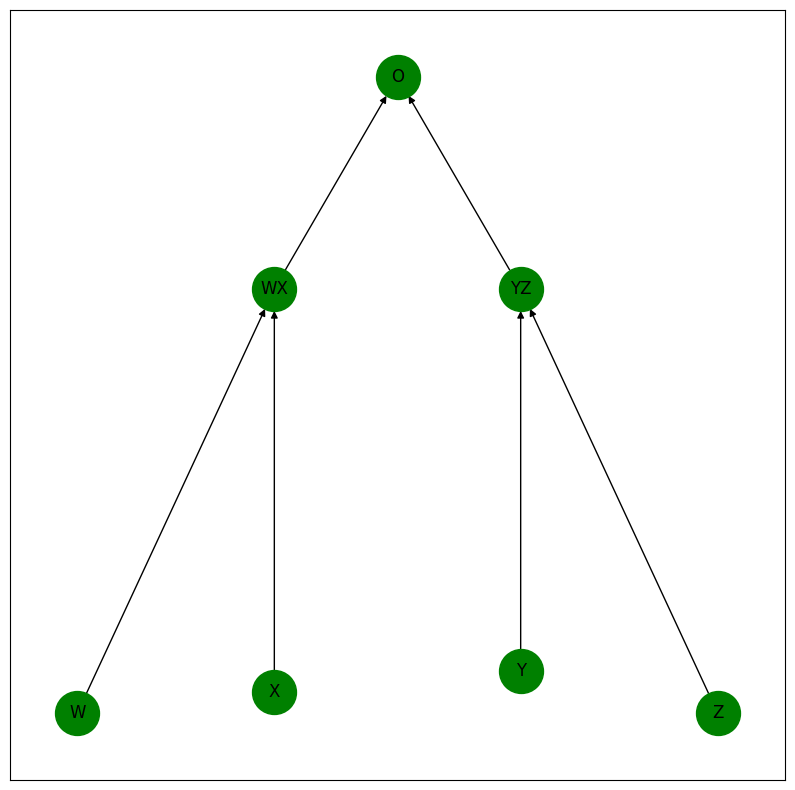

Timesteps: {'W': 0, 'X': 0, 'Y': 0, 'Z': 0, 'WX': 1, 'YZ': 1, 'O': 2}


In [6]:
equality_model.print_structure()
print("Timesteps:", equality_model.timesteps)

### The algorithm with no intervention

Let's first observe the behavior of the algorithm when we provide an input of the form `BBCD` with no interventions. Here is a visual depiction:

No intervention:
 defaultdict(None, {'W': array([ 0.28, -0.95]), 'X': array([ 0.28, -0.95]), 'Y': array([-0.45, -0.55]), 'Z': array([ 0.78, -0.83]), 'WX': True, 'YZ': False, 'O': False}) 



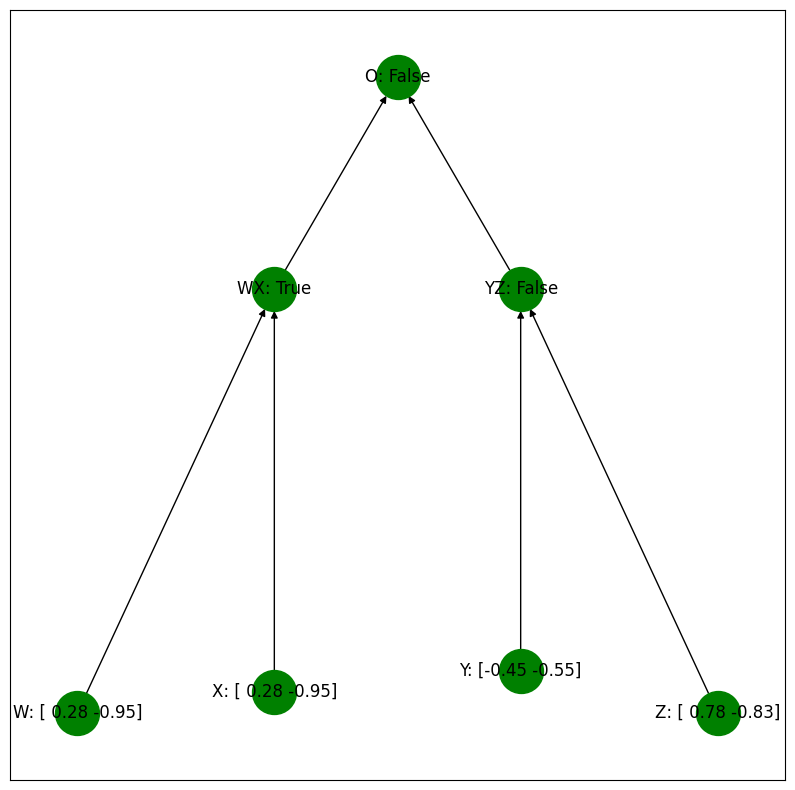

In [7]:
setting = equality_model.run_forward({"W": reps[0], "X": reps[0], "Y": reps[1], "Z": reps[3]})

print("No intervention:\n", setting, "\n")
equality_model.print_setting(setting)

### The algorithm with an intervention

Let's now see the behavior of the algorithm when we provide the input with an intervention setting **WX** to **False**. First, a visual depiction:

And then the same computation with `compute_A`:

Intervention setting WX to FALSE:



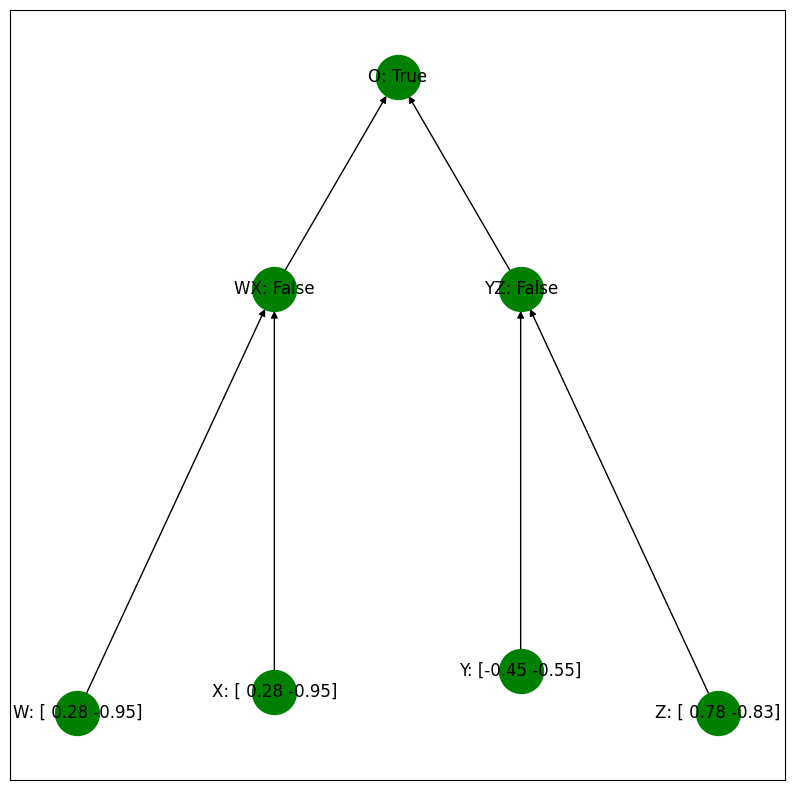

In [8]:
print("Intervention setting WX to FALSE:\n",)

equality_model.print_setting(equality_model.run_forward({"W": reps[0], "X": reps[0], "Y": reps[1], "Z": reps[3], "WX": False})
)

Notice that, in this example, even though the left two inputs are the same, the intervention has changed the intermediate prediction for those two inputs from **True** to **False**, and thus the algorithm outputs **True**, since **WX** and **YZ** are both **False**.

### The algorithm with an interchange intervention

Finally, let's observe the behavior of the algorithm when we provide the base input `BBCD` with an intervention setting **WX** to be the value it would be for the source input `ABCC`.

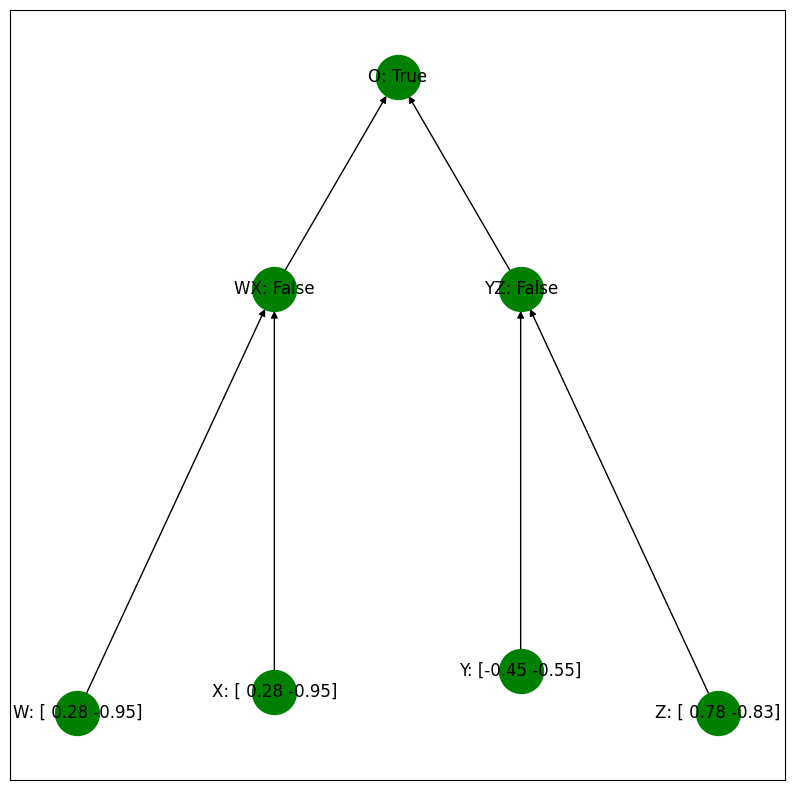

In [9]:
base = {"W": reps[0], "X": reps[0], "Y": reps[1], "Z": reps[3]}
source = {"W": reps[0], "X": reps[1], "Y": reps[2], "Z": reps[2]}
setting = equality_model.run_interchange(base, {"WX": source})
equality_model.print_setting(setting)

# Hand Crafting an MLP to Solve Hierarchical Equality

Before we train a network to solve the hierarchical equality task, first consider an analytical solution where we define a neural network to have weights that are handcrafted to solve the task by implementing the algorithm $\mathcal{A}$. The network is a two layer feedforward neural network that uses the ReLU function to compute the absolute difference between two vectors. 

In [10]:
config = MLPConfig(
    h_dim=embedding_dim * 4,
    activation_function="relu",
    n_layer=2,
    num_classes=2,
    pdrop=0.0,
)

In [11]:
config, tokenizer, handcrafted = create_mlp_classifier(config)

loaded model


The first layer of our handcrafted model computes:

$ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}]) = [max(\mathbf{a}-\mathbf{b}, 0), max(\mathbf{b}-\mathbf{a}, 0), max(\mathbf{c}-\mathbf{d}, 0), max(\mathbf{d}-\mathbf{c}, 0)]$


In [13]:
W1 = [
    [1, 0, -1, 0, 0, 0, 0, 0],
    [0, 1, 0, -1, 0, 0, 0, 0],
    [-1, 0, 1, 0, 0, 0, 0, 0],
    [0, -1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, -1, 0],
    [0, 0, 0, 0, 0, 1, 0, -1],
    [0, 0, 0, 0, -1, 0, 1, 0],
    [0, 0, 0, 0, 0, -1, 0, 1],
]
handcrafted.mlp.h[0].ff1.weight = torch.nn.Parameter(torch.FloatTensor(W1))
handcrafted.mlp.h[0].ff1.bias = torch.nn.Parameter(torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0]))

The second layer of our handcrafted model computes:

$ReLU(W_2ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}])) = [|\mathbf{a}-\mathbf{b}| - |\mathbf{c}-\mathbf{d}|, |\mathbf{c}-\mathbf{d}|-|\mathbf{a}-\mathbf{b}|, |\mathbf{a}-\mathbf{b}|, |\mathbf{c}-\mathbf{d}|,0,0,0,0]$


In [14]:
W2 = [
    [1, -1, 0, 1, 0, 0, 0, 0],
    [1, -1, 0, 1, 0, 0, 0, 0],
    [1, -1, 0, 1, 0, 0, 0, 0],
    [1, -1, 0, 1, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0, 0, 0],
]
handcrafted.mlp.h[1].ff1.weight = torch.nn.Parameter(
    torch.FloatTensor(W2).transpose(0, 1)
)
handcrafted.mlp.h[1].ff1.bias = torch.nn.Parameter(
    torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0])
)

The third layer of our handcrafted model computes the logits:

$W_3 ReLU(W_2ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}])) = [||\mathbf{a}-\mathbf{b}| - |\mathbf{c}-\mathbf{d}|| -0.999999|\mathbf{a}-\mathbf{b}|-0.999999|\mathbf{c}-\mathbf{d}|, 0]$

In [15]:
W3 = [[1, 0], [1, 0], [-0.999999, 0], [-0.999999, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
handcrafted.score.weight = torch.nn.Parameter(torch.FloatTensor(W3).transpose(0, 1))
handcrafted.score.bias = torch.nn.Parameter(torch.FloatTensor([0, 0.00000000000001]))

**We can now use the causal model of $\mathcal{A}$ that we created to generate a labeled dataset for the hierarchical equality task** and show that our handcrafted network solves the task with perfect accuracy.

In [16]:
n_examples = 100000

examples = equality_model.generate_factual_dataset(n_examples, equality_model.sample_input_tree_balanced)

X = torch.stack([example['input_ids'] for example in examples])
y = torch.stack([example['labels'] for example in examples])

In [17]:
preds = handcrafted.forward(inputs_embeds=X)

print("Train Results")
print(classification_report(y, preds[0].argmax(1)))

Train Results
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     50050
         1.0       1.00      1.00      1.00     49950

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



# Causal abstraction

The theory of **causal abstraction** describes the conditions that must hold for the high-level tree structured algorithm to be a simplified and faithful description of the neural network. To perform causal abstraction analysis, we need to align high-level variables in our hypothesized algorithm $\mathcal{A}$ with sets of low-level variables in the low-level neural network $\mathcal{N}$. 

In essence: $\mathcal{A}$ is a causal abstraction of a $\mathcal{N}$ if and only if $\mathcal{A}$ and $\mathcal{N}$ provides the same output for all interchange interventions that target aligned variables.

For our handcrafted network, **we align the first four neurons in the first feed-forward layer with the high-level variable 'WX' and align the other four neurons in that layer with 'YZ'**. Below, we create an IntervenableConfig that allows us to taget the first four and last four neurons of the first layer for an interchange intervention. 

In [19]:
config = IntervenableConfig(
    model_type=type(handcrafted),
    representations=[
        RepresentationConfig(
            0,  # layer
            "block_output",  # component
            subspace_partition=[[0, 4], [4, 8]],
        ),
        RepresentationConfig(
            0,  # layer
            "block_output",  # component
            subspace_partition=[[0, 4], [4, 8]],
        ),
    ],
    intervention_types=VanillaIntervention,
)
handcrafted = IntervenableModel(config, handcrafted)

Next we create a counterfactual equality dataset that includes interchange intervention examples. We first define a function that creates an id for the three possible high-level interventions, namely targetting 'WX', targetting 'YZ', and targetting them both.

In [21]:
def intervention_id(intervention):
    if "WX" in intervention and "YZ" in intervention:
        return 2
    if "WX" in intervention:
        return 0
    if "YZ" in intervention:
        return 1


data_size = 2048
batch_size = 16
dataset = equality_model.generate_counterfactual_dataset(
    data_size,
    intervention_id,
    batch_size,
    #device="cuda:0",
    sampler=equality_model.sample_input_tree_balanced,
)

This dataset has the following components:

* `input_ids`: a regular set of train examples
* `base_labels`: a regular set of train labels
* `source_input_ids`: sets additional training inputs sets (here, two sets) for interchange interventions
* `labels`: a list of labels if interchange interventions are performed with 'source_input_ids'
* `intervention_id`: a list of intervention sites (here, all `0` corresponding to our key for "V1")

In [36]:
print(dataset[0]["input_ids"])
print(dataset[0]["source_input_ids"])
print(dataset[0]["base_labels"])
print(dataset[0]["labels"])
print(dataset[0]["intervention_id"])

tensor([ 0.0700,  0.9500,  0.0700,  0.9500, -0.8100, -0.8100, -0.4500, -0.5500])
tensor([[ 0.2800, -0.9500,  0.2800, -0.9500,  0.2800, -0.9500,  0.9100, -0.3300],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([0.])
tensor([0.])
tensor([0])


To evaluate the model on this dataset, we loop through batches and peform interchange interventions based on the intervention_id. 
* When the id is 0, the first four neurons in the first layer are targetted ('WX' is targetted at the high-level)
* When the id is 1, the last four neurons in the first layer are targetted ('YZ' is targetted at the high-level)
* When the id is 2, all of the neurons in the first layer are targetted ('WX' and 'YZ' are both targetted at the high-level) 

In [30]:
handcrafted.to("cuda:0")
for parameter in handcrafted.get_trainable_parameters():
    parameter.to("cuda:0")
preds = []

# Intervenable model forward :
# base,
# sources: Optional[List] = None, 
# unit_locations: Optional[Dict] = None,
# source_representations: Optional[Dict] = None,
# subspaces: Optional[List] = None,
# labels: Optional[torch.LongTensor] = None,
# output_original_output: Optional[bool] = False,
# return_dict: Optional[bool] = None,
# use_cache: Optional[bool] = True,

for batch in DataLoader(dataset, batch_size):
    batch["input_ids"] = batch["input_ids"].unsqueeze(1)
    batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
    if batch["intervention_id"][0] == 2:  # Intervention on both high-level variables
        _, counterfactual_outputs = handcrafted(
            {"inputs_embeds": batch["input_ids"]},
            [
                {"inputs_embeds": batch["source_input_ids"][:, 0]},
                {"inputs_embeds": batch["source_input_ids"][:, 1]},
            ],
            {
                "sources->base": (
                    [[[0]] * batch_size, [[0]] * batch_size],
                    [[[0]] * batch_size, [[0]] * batch_size],
                )
            },
            subspaces=[[[0]] * batch_size, [[1]] * batch_size],
        )
    elif (
        batch["intervention_id"][0] == 0
    ):  # Intervention on just the high-level variable 'WX'
        _, counterfactual_outputs = handcrafted(
            {"inputs_embeds": batch["input_ids"]},  # base
            [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],  # sources
            {"sources->base": ([[[0]] * batch_size, None], [[[0]] * batch_size, None])},  # unit_locations
            subspaces=[[[0]] * batch_size, None],
        )
    elif (
        batch["intervention_id"][0] == 1
    ):  # Intervention on just the high-level variable 'YZ'
        _, counterfactual_outputs = handcrafted(
            {"inputs_embeds": batch["input_ids"]},
            [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
            {"sources->base": ([None, [[0]] * batch_size], [None, [[0]] * batch_size])},
            subspaces=[None, [[1]] * batch_size],
        )
    preds.append(counterfactual_outputs[0])

In [45]:
len([[[0]] * batch_size, None][0])

16

In [31]:
preds = torch.cat(preds)

Below, we can see that our handcrafted neural network is a perfect implementation of the high-level algorithm.

In [32]:
print(
    classification_report(
        torch.tensor([x["labels"] for x in dataset]).cpu(), preds.argmax(1).cpu()
    )
)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       997
         1.0       1.00      1.00      1.00      1051

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



# Training an MLP to Solve Hierarchical Equality

We've now seen how to perform causal abstraction analysis on a simple handcrafted neural networks. We turn now to training a neural network to perform the hierarchical equality task with a 4 dimensional vector embedding for each object. We define an input sampler to provide an infinite stream of new entities, rather than relying on a fixed set of vector representations.

In [33]:
embedding_dim = 4


def input_sampler():
    A = randvec(4)
    B = randvec(4)
    C = randvec(4)
    D = randvec(4)
    x = random.randint(1, 4)
    if x == 1:
        return {"W": A, "X": B, "Y": C, "Z": D}
    elif x == 2:
        return {"W": A, "X": A, "Y": B, "Z": B}
    elif x == 3:
        return {"W": A, "X": A, "Y": C, "Z": D}
    elif x == 4:
        return {"W": A, "X": B, "Y": C, "Z": C}

In [34]:
n_examples = 1048576
batch_size = 1024

examples = equality_model.generate_factual_dataset(n_examples, input_sampler)

X = torch.stack([example['input_ids'] for example in examples])
y = torch.stack([example['labels'] for example in examples])

# X = X.unsqueeze(1)

The examples in this dataset are 8-dimensional vectors: the concatenation of 4 2-dimensional vectors. Here's the first example with its label:

In [35]:
X[0], y[0]

(tensor([-0.7200,  0.6300,  1.0000,  0.6900, -0.7200,  0.6300,  1.0000,  0.6900,
          0.0800, -0.8800, -0.0400, -0.0400, -0.5200, -0.8500, -0.6400,  0.6400]),
 tensor([0.]))

The label for this example is determined by whether the equality value for the first two inputs matches the equality value for the second two inputs:

In [36]:
left = torch.equal(X[0][:embedding_dim], X[0][embedding_dim : embedding_dim * 2])

left

True

In [37]:
right = torch.equal(
    X[0][embedding_dim * 2 : embedding_dim * 3], X[0][embedding_dim * 3 :]
)

right

False

In [38]:
int(left == right)

0

We define a three layer neural network with a ReLU activation function this task:

In [39]:
config = MLPConfig(
    h_dim=embedding_dim * 4,
    activation_function="relu",
    n_layer=3,
    num_classes=2,
    pdrop=0.0,
)
config, tokenizer, trained = create_mlp_classifier(config)
trained.train()

loaded model


MLPForClassification(
  (mlp): MLPModel(
    (dropout): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-2): 3 x MLPBlock(
        (ff1): Linear(in_features=16, out_features=16, bias=True)
        (act): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (score): Linear(in_features=16, out_features=2, bias=True)
)

In [40]:
train_ds = Dataset.from_dict(
    {
        "labels": [
            torch.FloatTensor([0, 1]) if i == 1 else torch.FloatTensor([1, 0])
            for i in y
        ],
        "inputs_embeds": X,
    }
)

In [41]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    learning_rate=0.001,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none",
)

trainer = Trainer(
    model=trained,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=train_ds,
    compute_metrics=lambda x: {
        "accuracy": classification_report(
            x[0].argmax(1), x[1].argmax(1), output_dict=True
        )["accuracy"]
    },
)

This neural network achieves perfect performance on its train set:

In [42]:
_ = trainer.train()

  0%|          | 0/3072 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed
Checkpoint destination directory test_trainer\checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.6401, 'grad_norm': 0.23116283118724823, 'learning_rate': 0.0008372395833333334, 'epoch': 0.49}


Checkpoint destination directory test_trainer\checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.195, 'grad_norm': 0.18332688510417938, 'learning_rate': 0.0006744791666666667, 'epoch': 0.98}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.07157168537378311, 'eval_accuracy': 0.9790763854980469, 'eval_runtime': 37.061, 'eval_samples_per_second': 28293.236, 'eval_steps_per_second': 27.63, 'epoch': 1.0}


Checkpoint destination directory test_trainer\checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0472, 'grad_norm': 0.15438705682754517, 'learning_rate': 0.00051171875, 'epoch': 1.46}


Checkpoint destination directory test_trainer\checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.025, 'grad_norm': 0.1841142624616623, 'learning_rate': 0.00034895833333333334, 'epoch': 1.95}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.019501574337482452, 'eval_accuracy': 0.9946937561035156, 'eval_runtime': 37.7091, 'eval_samples_per_second': 27806.989, 'eval_steps_per_second': 27.155, 'epoch': 2.0}


Checkpoint destination directory test_trainer\checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0177, 'grad_norm': 0.18471458554267883, 'learning_rate': 0.00018619791666666665, 'epoch': 2.44}


Checkpoint destination directory test_trainer\checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0149, 'grad_norm': 0.15878142416477203, 'learning_rate': 2.34375e-05, 'epoch': 2.93}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.014224954880774021, 'eval_accuracy': 0.9962148666381836, 'eval_runtime': 42.0755, 'eval_samples_per_second': 24921.316, 'eval_steps_per_second': 24.337, 'epoch': 3.0}
{'train_runtime': 257.663, 'train_samples_per_second': 12208.692, 'train_steps_per_second': 11.923, 'train_loss': 0.15329135081265122, 'epoch': 3.0}


Next we create a separate causal model with vector representations distinct from those used in training:

In [43]:
variables = ["W", "X", "Y", "Z", "WX", "YZ", "O"]

number_of_test_entities = 100

reps = [randvec(embedding_dim) for _ in range(number_of_test_entities)]
values = {variable: reps for variable in ["W", "X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {
    "W": [],
    "X": [],
    "Y": [],
    "Z": [],
    "WX": ["W", "X"],
    "YZ": ["Y", "Z"],
    "O": ["WX", "YZ"],
}


def FILLER():
    return reps[0]


functions = {
    "W": FILLER,
    "X": FILLER,
    "Y": FILLER,
    "Z": FILLER,
    "WX": lambda x, y: np.array_equal(x, y),
    "YZ": lambda x, y: np.array_equal(x, y),
    "O": lambda x, y: x == y,
}

pos = {
    "W": (0, 0),
    "X": (1, 0.1),
    "Y": (2, 0.2),
    "Z": (3, 0),
    "WX": (1, 2),
    "YZ": (2, 2),
    "O": (1.5, 3),
}


test_equality_model = CausalModel(variables, values, parents, functions, pos=pos)

hi!


Our trained model generalizes perfectly this test set consisting of distinct vectors:

In [44]:
examples = test_equality_model.generate_factual_dataset(10000, input_sampler)
print("Test Results")

test_ds = Dataset.from_dict(
    {
        "labels": [
            torch.FloatTensor([0, 1]) if example['labels'].item() == 1 else torch.FloatTensor([1, 0])
            for example in examples
        ],
        "inputs_embeds": torch.stack([example['input_ids'] for example in examples]),
    }
)

test_preds = trainer.predict(test_ds)
y_test = [example['labels'].item() for example in examples]

print(classification_report(y_test, test_preds[0].argmax(1)))

Test Results


  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5026
         1.0       1.00      0.99      1.00      4974

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



Does it implement our high-level model of the problem, though?

# Distributed Alignment Search



We previously handcrafted the weights of a network so the two high-level variables are perfectly stored in two non-overlapping sets of neurons in the first layer of the network. However, the trained network won't have axis aligned representations of high-level concepts. Rather, the two high-level variables will be encoded in multidimensional linear subspaces of the first layer in the network.  

To learn these subspaces, we define an IntervenableConfig that allows us to target the first layer of in the network after it has been rotated by an orthogonal matrix:

In [45]:
config = IntervenableConfig(
    model_type=type(trained),
    representations=[
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligne with tokens
            1,  # max number of unit
            subspace_partition=None,  # binary partition with equal sizes
            intervention_link_key=0,
        ),
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligne with tokens
            1,  # max number of unit
            subspace_partition=None,  # binary partition with equal sizes,
            intervention_link_key=0,
        ),
    ],
    intervention_types=RotatedSpaceIntervention,
)

In [46]:
intervenable = IntervenableModel(config, trained, use_fast=True)
intervenable.set_device("cuda")
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


In [47]:
epochs = 10
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(dataset) * epochs

t_total = int(len(dataset) * epochs)
optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=0.001)


def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        total_count += 1
        correct_count += eval_pred == eval_label
    accuracy = float(correct_count) / float(total_count)
    return {"accuracy": accuracy}


def compute_loss(outputs, labels):
    CE = torch.nn.CrossEntropyLoss()
    return CE(outputs, labels)


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

In [68]:
def input_sampler(*args, **kwargs):
    A = randvec(4)
    B = randvec(4)
    C = randvec(4)
    D = randvec(4)
    if kwargs.get('output_var', None) is None:
        return random.choice([
            {"W": A, "X": B, "Y": C, "Z": D},
            {"W": A, "X": A, "Y": B, "Z": B},
            {"W": A, "X": A, "Y": C, "Z": D},
            {"W": A, "X": B, "Y": C, "Z": C}
        ])
    elif kwargs['output_var'] == 'WX' and kwargs['output_var_value']:
        return random.choice([
            {"W": A, "X": A, "Y": C, "Z": D},
            {"W": A, "X": A, "Y": C, "Z": C}
        ])
    elif kwargs['output_var'] == 'WX' and not kwargs['output_var_value']:
        return random.choice([
            {"W": A, "X": B, "Y": C, "Z": D},
            {"W": A, "X": B, "Y": C, "Z": C}
        ])
    elif kwargs['output_var'] == 'YZ' and kwargs['output_var_value']:
        return random.choice([
            {"W": A, "X": B, "Y": C, "Z": C},
            {"W": A, "X": A, "Y": C, "Z": C}
        ])
    else:
        return random.choice([
            {"W": A, "X": B, "Y": C, "Z": D},
            {"W": A, "X": A, "Y": C, "Z": D}
        ])

We again generate a counterfactual dataset using our high-level causal model:

In [69]:
n_examples = 1280000
batch_size = 6400
train_dataset = equality_model.generate_counterfactual_dataset(
    n_examples, intervention_id, batch_size, sampler=input_sampler
)

Then we train the orthgonal matrix to be such that the first four dimensions in the rotated space encode the high-level variable 'WX' and the second four dimensions encode the high-level variable 'YZ'. 

Again, we check the intervention_id for each batch of training data in order to determine whether to intervene of the first four rotated dimensions ('WX' is targetted at the high-level), the last four rotated dimensions ('YZ' is targetted at the high-level), or all of the dimensions ('WX' and 'YZ' are both targetted at the high-level). 

We can train the rotation matrix such that we get perfect interchange intervention accuracy, meaning the trained network perfectly implements the high-level algorithm on the training data.

In [80]:
intervenable.model.train()  # train enables drop-off but no grads
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

for epoch in train_iterator:
    epoch_iterator = tqdm(
        DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=batched_random_sampler(train_dataset),
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True,
    )
    for batch in epoch_iterator:
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
        batch_size = batch["input_ids"].shape[0]
        for k, v in batch.items():
            if v is not None and isinstance(v, torch.Tensor):
                batch[k] = v.to("cuda")

        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [
                    {"inputs_embeds": batch["source_input_ids"][:, 0]},
                    {"inputs_embeds": batch["source_input_ids"][:, 1]},
                ],
                {
                    "sources->base": (
                        [[[0]] * batch_size, [[0]] * batch_size],
                        [[[0]] * batch_size, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],
                {
                    "sources->base": (
                        [[[0]] * batch_size, None],
                        [[[0]] * batch_size, None],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    None,
                ],
            )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
                {
                    "sources->base": (
                        [None, [[0]] * batch_size],
                        [None, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    None,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        eval_metrics = compute_metrics(
            counterfactual_outputs[0].argmax(1), batch["labels"].squeeze()
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs[0], batch["labels"].squeeze().to(torch.long)
        )

        epoch_iterator.set_postfix({"loss": loss, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()
        total_step += 1

intervention trainable parameters:  256


Epoch: 0: 0it [00:00, ?it/s] [00:00<?, ?it/s]

Epoch: 0: 200it [01:17,  2.59it/s, loss=tensor(0.4580, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.872]
Epoch: 1: 200it [00:54,  3.69it/s, loss=tensor(0.4646, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.89] 
Epoch: 2: 200it [00:53,  3.71it/s, loss=tensor(0.1925, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.962]
Epoch: 3: 200it [00:53,  3.71it/s, loss=tensor(0.5047, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.837]
Epoch: 4: 200it [00:54,  3.70it/s, loss=tensor(0.1448, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.969]
Epoch: 5: 200it [00:52,  3.81it/s, loss=tensor(0.1444, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.967]
Epoch: 6: 200it [00:58,  3.40it/s, loss=tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.97] 
Epoch: 7: 200it [01:04,  3.09it/s, loss=tensor(0.1703, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.958]
Epoch: 8: 200it [01:05,  3.07it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<NllLossBackward0>), acc

What's more, is it generalizes unseen test data:

In [81]:
test_dataset = test_equality_model.generate_counterfactual_dataset(
    10000, intervention_id, batch_size, device="cuda:0", sampler=input_sampler
)

In [82]:
eval_labels = []
eval_preds = []
with torch.no_grad():
    epoch_iterator = tqdm(DataLoader(test_dataset, batch_size), desc=f"Test")
    for step, batch in enumerate(epoch_iterator):
        for k, v in batch.items():
            if v is not None and isinstance(v, torch.Tensor):
                batch[k] = v.to("cuda")
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [
                    {"inputs_embeds": batch["source_input_ids"][:, 0]},
                    {"inputs_embeds": batch["source_input_ids"][:, 1]},
                ],
                {
                    "sources->base": (
                        [[[0]] * batch_size, [[0]] * batch_size],
                        [[[0]] * batch_size, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],
                {
                    "sources->base": (
                        [[[0]] * batch_size, None],
                        [[[0]] * batch_size, None],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    None,
                ],
            )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
                {
                    "sources->base": (
                        [None, [[0]] * batch_size],
                        [None, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    None,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        eval_labels += [batch["labels"]]
        eval_preds += [torch.argmax(counterfactual_outputs[0], dim=1)]
print(classification_report(torch.cat(eval_labels).cpu(), torch.cat(eval_preds).cpu()))

Test:   0%|          | 0/2 [00:00<?, ?it/s]

Test: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      6407
         1.0       0.96      0.98      0.97      6393

    accuracy                           0.97     12800
   macro avg       0.97      0.97      0.97     12800
weighted avg       0.97      0.97      0.97     12800

